(haldane-hwf-nb)=
# Haldane model hybrid Wannier functions

Calculates Berry phases for the Haldane model and compares it to the
hybrid Wannier centers for a ribbon of the Haldane model.

First, compute bulk Wannier centers along direction 1
Then, cut a ribbon that extends along direction 0, and compute
both the edge states and the finite hybrid Wannier centers
along direction 1.

In [1]:
from pythtb import TBModel, WFArray, Mesh
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# define lattice vectors and orbitals and make model
lat = [[1.0, 0.0], [0.5, np.sqrt(3.0) / 2.0]]
orb = [[1.0 / 3.0, 1.0 / 3.0], [2.0 / 3.0, 2.0 / 3.0]]
my_model = TBModel(2, 2, lat, orb)

# set model parameters
delta = -0.2
t = -1.0
t2 = 0.05 - 0.15j
t2c = t2.conjugate()

# set on-site energies and hoppings
my_model.set_onsite([-delta, delta])
my_model.set_hop(t, 0, 1, [0, 0])
my_model.set_hop(t, 1, 0, [1, 0])
my_model.set_hop(t, 1, 0, [0, 1])
my_model.set_hop(t2, 0, 0, [1, 0])
my_model.set_hop(t2, 1, 1, [1, -1])
my_model.set_hop(t2, 1, 1, [0, 1])
my_model.set_hop(t2c, 1, 1, [1, 0])
my_model.set_hop(t2c, 0, 0, [1, -1])
my_model.set_hop(t2c, 0, 0, [0, 1])

In [4]:
# Fermi level, relevant for edge states of ribbon
efermi = 0.25

In [5]:
# number of discretized sites or k-points in the mesh in directions 0 and 1
nk0 = 100
nk1 = 10

mesh = Mesh(my_model)
mesh.build_grid(shape_k=(nk0, nk1), full_grid=True)

In [6]:
my_array = WFArray(my_model, mesh)
my_array.solve_k_mesh()

Imposing PBC in direction 0 along mesh and 0-th k-component
Imposing PBC in direction 1 along mesh and 1-th k-component


In [7]:
phi_1 = my_array.berry_phase(occ=[0], dir=1, contin=True)

In [8]:
# create Haldane ribbon that is finite along direction 1
ribbon_model = my_model.cut_piece(nk1, fin_dir=1, glue_edgs=False)
(k_vec, k_dist, k_node) = ribbon_model.k_path([0.0, 0.5, 1.0], nk0, report=False)
k_label = [r"$0$", r"$\pi$", r"$2\pi$"]

In [ ]:
# solve ribbon model to get eigenvalues and eigenvectors
rib_eval, rib_evec = ribbon_model.solve_ham(k_vec, return_eigvecs=True)
# shift bands so that the fermi level is at zero energy
rib_eval -= efermi

In [10]:
# find k-points at which number of states below the Fermi level changes
jump_k = []
for i in range(rib_eval.shape[0] - 1):
    nocc_i = np.sum(rib_eval[i, :] < 0.0)
    nocc_ip = np.sum(rib_eval[i + 1, :] < 0.0)
    if nocc_i != nocc_ip:
        jump_k.append(i)

Plotting the expectation value of the position operator for states in the ribbon and hybrid Wannier function centers.

Bottom plot shows Wannier center flow, with green lines indicating bulk Wannier centers and black dots indicating finite-ribbon Wannier centers. Compare with Fig. 3 in Phys. Rev. Lett. 102, 107603 (2009).

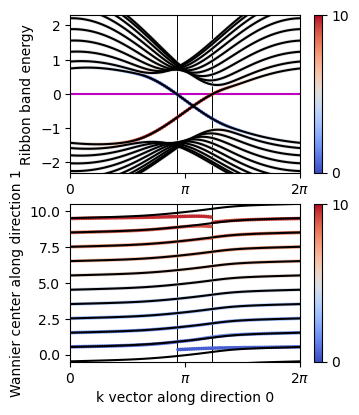

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1)

# plot bandstructure of the ribbon
for n in range(rib_eval.shape[1]):
    ax1.plot(k_dist, rib_eval[:, n], c="k", zorder=-50)

# color bands according to expectation value of y operator (red=top, blue=bottom)
for i in range(rib_evec.shape[0]):
    # get expectation value of the position operator for states at i-th kpoint
    pos_exp = ribbon_model.position_expectation(rib_evec[i, :], dir=1)

    # plot states according to the expectation value
    s = ax1.scatter(
        [k_vec[i]] * rib_eval.shape[1],
        rib_eval[i, :],
        c=pos_exp,
        s=7,
        marker="o",
        cmap="coolwarm",
        edgecolors="none",
        vmin=0.0,
        vmax=float(nk1),
        zorder=-100,
    )

# color scale
fig.colorbar(s, None, ax1, ticks=[0.0, float(nk1)])

# plot Fermi energy
ax1.axhline(0.0, c="m", zorder=-200)

# vertical lines show crossings of surface bands with Fermi energy
for ax in [ax1, ax2]:
    for i in jump_k:
        ax.axvline(
            x=(k_vec[i] + k_vec[i + 1]) / 2.0, linewidth=0.7, color="k", zorder=-150
        )

# tweaks
ax1.set_ylabel("Ribbon band energy")
ax1.set_ylim(-2.3, 2.3)

# plot bulk hybrid Wannier center positions and their periodic images
for j in range(-1, nk1 + 1):
    ax2.plot(k_vec, float(j) + phi_1 / (2 * np.pi), "k-", zorder=-50)

# plot finite centers of ribbon along direction 1
for i in range(rib_evec.shape[0]):
    # get occupied states only (those below Fermi level)
    occ_evec = rib_evec[i, rib_eval[i, :] < 0.0]
    # get centers of hybrid wannier functions
    hwfc = ribbon_model.position_hwf(occ_evec, 1)
    # plot centers
    s = ax2.scatter(
        [k_vec[i]] * hwfc.shape[0],
        hwfc,
        c=hwfc,
        s=7,
        marker="o",
        cmap="coolwarm",
        edgecolors="none",
        vmin=0.0,
        vmax=float(nk1),
        zorder=-100,
    )

# color scale
fig.colorbar(s, None, ax2, ticks=[0, float(nk1)])

# tweaks
ax2.set_xlabel(r"k vector along direction 0")
ax2.set_ylabel(r"Wannier center along direction 1")
ax2.set_ylim(-0.5, nk1 + 0.5)

# label both axes
for ax in [ax1, ax2]:
    ax.set_xlim(k_node[0], k_node[-1])
    ax.set_xticks(k_node)
    ax.set_xticklabels(k_label)